In [5]:
!pip install onboard.client
from onboard.client import RtemClient
from onboard.client.models import PointSelector, TimeseriesQuery, PointData
from onboard.client.dataframes import points_df_from_streaming_timeseries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pytz
from datetime import datetime, timezone, timedelta
from google.colab import files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
api_key = ...
client = RtemClient(api_key=api_key)

In [7]:
query = PointSelector()
query.buildings = [286]
points_286 = client.select_points(query)['points']
sensor_metadata_286 = pd.DataFrame(client.get_points_by_ids(points_286))
sensor_metadata_286.head()


,id,building_id,last_updated,first_updated,device,network_device,objectId,name,description,units,tagged_units,raw_unit_id,value,type,point_type_id,measurement_id,datasource_hash,topic,state_text,equip_id
0,212992,286,1.545713e+12,1.530418e+12,,None,,,AC-3W_Occupancy: Active,Occ,None,18,Unoccupied,Occupancy Status,177,10,75094e08ea81d611e21c2b0b1db07c2b,nyserda+0000085492+ac-3W+AC-3W_Occupancy: Active,None,20355
1,212993,286,1.564631e+12,1.561954e+12,,None,,,AC-3W_Outdoor Air Damper Capacity,,None,23,100,Virtual,434,18,4638f98763181b9d21684480740ad68c,nyserda+0000085492+ac-3W+AC-3W_Outdoor Air Dam...,None,20355
2,212994,286,1.564631e+12,1.561954e+12,,None,,,AC-3W_Space Pressure Control,,None,23,No,Virtual,434,18,f23fe3b53287ec398f268e7bd02f568f,nyserda+0000085492+ac-3W+AC-3W_Space Pressure ...,None,20355
3,212995,286,1.564631e+12,1.561954e+12,,None,,,AC-3W_Supply Fan Type,,None,23,Variable Speed,Virtual,434,18,c93e879f0cea069f5902b31e8ffeed56,nyserda+0000085492+ac-3W+AC-3W_Supply Fan Type,None,20355
4,212996,286,1.564631e+12,1.561954e+12,,None,,,AC-3W_Outdoor Air Enthalpy (Reference Value),BTU/lb,None,28,35.5,Outside Air Enthalpy,242,24,84d7480594e3ad473da0af0f7beb6b49,nyserda+0000085492+ac-3W+AC-3W_Outdoor Air Ent...,None,20355


In [9]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [16]:
is_float = [is_number(s) for s in sensor_metadata_286['value'].tolist()]
temp_or_hum = ((sensor_metadata_286['type']=='Outside Air Temperature') & (sensor_metadata_286['type']=='Outside Air Humidity'))
elec_meter = sensor_metadata_286['id']==198672
floor15 = sensor_metadata_286['description'].str.contains('6W')
nosetpoint = sensor_metadata_286['description'].str.lower().str.contains('setpoint')
onoff = sensor_metadata_286['units'] == 'On/Off'

sensor_metadata_286_f15 = sensor_metadata_286[is_float & ~nosetpoint & ~onoff & (temp_or_hum | elec_meter | floor15)]
sensor_metadata_286_f15

,id,building_id,last_updated,first_updated,device,network_device,objectId,name,description,units,tagged_units,raw_unit_id,value,type,point_type_id,measurement_id,datasource_hash,topic,state_text,equip_id
37,213029,286,1.564631e+12,1.530418e+12,,None,,,AC-6W_Cool Output %,%,None,3,0,Cooling Output,327,23,db497b9d0241c3f8ebdb330b2bc24e12,nyserda+0000085492+ac-6W+AC-6W_Cool Output %,None,20358
40,213032,286,1.564631e+12,1.530418e+12,,None,,,AC-6W_Heat Output %,%,None,3,0,Heating Output,240,23,25165c7a3352de4bab9599a54843f2b6,nyserda+0000085492+ac-6W+AC-6W_Heat Output %,None,20358
44,213036,286,1.564631e+12,1.561954e+12,,None,,,AC-6W_Number of Comp,,None,23,4,Virtual,434,18,c7953300166a07b75da5715e2404265e,nyserda+0000085492+ac-6W+AC-6W_Number of Comp,None,20358
46,213038,286,1.564631e+12,1.561954e+12,,None,,,AC-6W_Outdoor Air Damper Capacity,,None,23,100,Virtual,434,18,52808bd649bfdea6d655902c3480d5bd,nyserda+0000085492+ac-6W+AC-6W_Outdoor Air Dam...,None,20358
49,213041,286,1.564631e+12,1.561954e+12,,None,,,AC-6W_Outdoor Air Damper Output,%,None,3,0,Outside Air Damper Position,148,7,03b592901a8f7f59af83c4b1c6edbd16,nyserda+0000085492+ac-6W+AC-6W_Outdoor Air Dam...,None,20358
50,213042,286,1.564631e+12,1.561954e+12,,None,,,AC-6W_Outdoor Air Enthalpy (Reference Value),BTU/lb,None,28,35.5,Outside Air Enthalpy,242,24,298124be67e018017f8d0c3c4a8da99b,nyserda+0000085492+ac-6W+AC-6W_Outdoor Air Ent...,None,20358
51,213043,286,1.564631e+12,1.561954e+12,,None,,,AC-6W_Outdoor Air Temp,F,None,2,77.2,Outside Air Temperature,76,1,1d88eee5eb82736d3bfedd368d689e05,nyserda+0000085492+ac-6W+AC-6W_Outdoor Air Temp,None,20358
52,213044,286,1.564631e+12,1.561954e+12,,None,,,AC-6W_Return Air Temp,F,None,2,75.3,Return Air Temperature,85,1,44d4fcde1d1cfdac4ef2106f1508b5d8,nyserda+0000085492+ac-6W+AC-6W_Return Air Temp,None,20358
53,213045,286,1.564631e+12,1.530418e+12,,None,,,AC-6W_Space Temp,F,None,2,74.5,Zone Temperature,77,1,4b1f6ceb6616ac33b42b62b4a6deb75b,nyserda+0000085492+ac-6W+AC-6W_Space Temp,None,20358
54,213046,286,1.564631e+12,1.561954e+12,,None,,,AC-6W_Supply Air Press,psi,None,5,0,Supply Air Static Pressure,423,37,7351763b1254f9fcbe1fbc4d37499bc2,nyserda+0000085492+ac-6W+AC-6W_Supply Air Press,None,20358


In [11]:
point_ids = sensor_metadata_286_f15.iloc[:,0].tolist()
columns_renamed = [(str(pt)+"_"+ des) for pt,des in zip(point_ids, sensor_metadata_286_f15.iloc[:,8].tolist())]
columns_renamed_dict = dict(zip(point_ids, columns_renamed))


In [12]:
print(sensor_metadata_286_f15.first_updated.apply(lambda x: datetime.fromtimestamp(x/1000, timezone.utc)).max())
print(sensor_metadata_286_f15.last_updated.apply(lambda x: datetime.fromtimestamp(x/1000, timezone.utc)).min())

2019-07-01 04:00:00+00:00
2019-07-31 14:00:00+00:00


In [13]:
# Select your timezone
tz = pytz.timezone('UTC')

# Select your date and time (time is optional)
start = datetime(2019,7,1,0,0,0).replace(tzinfo=tz)
end = datetime(2019,7,31,0,0,0).replace(tzinfo=tz)

print(f"from {start} to {end}")

from 2019-07-01 00:00:00+00:00 to 2019-07-31 00:00:00+00:00


In [17]:
timeseries_query = TimeseriesQuery(point_ids = sensor_metadata_286_f15['id'].tolist(), start = start, end = end)

# Exceute query (will return and object)
query_results = client.stream_point_timeseries(timeseries_query)

# Convert to dataframe
timeseries_b286_f6 = points_df_from_streaming_timeseries(query_results)
timeseries_b286_f6

,timestamp,213048,213052,213029,213032,213036,213038,213041,213042,213043,213044,213045,213046
0,2019-07-01T04:00:00Z,85.2,724.0,0.0,0.0,None,None,0.0,27.9,84.6,83.4,79.3,0.000000
1,2019-07-01T04:15:00Z,85.2,716.0,0.0,0.0,None,None,0.0,27.8,84.8,83.4,79.3,0.000000
2,2019-07-01T04:30:00Z,73.1,703.0,14.0,0.0,None,None,0.0,27.8,81.9,83.4,79.1,4.428943
3,2019-07-01T04:45:00Z,66.8,680.0,51.0,0.0,None,None,0.0,27.8,82.9,80.1,79.1,21.037480
4,2019-07-01T05:00:00Z,56.0,664.0,60.0,0.0,None,None,0.0,27.8,80.9,78.5,78.4,19.930244
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2859,2019-07-30T22:45:00Z,57.0,NaN,70.0,0.0,None,None,0.0,36.2,80.4,71.7,73.8,22.698334
2860,2019-07-30T23:00:00Z,57.0,NaN,70.0,0.0,None,None,0.0,36.2,80.4,71.7,73.8,23.805569
2861,2019-07-30T23:15:00Z,56.8,NaN,70.0,0.0,None,None,0.0,36.7,80.4,71.5,73.8,24.082378
2862,2019-07-30T23:30:00Z,56.7,NaN,70.0,0.0,None,None,0.0,36.7,80.3,71.4,73.8,25.466423


In [18]:
timeseries_b286_f6["timestamp"] = pd.to_datetime(timeseries_b286_f6['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
timeseries_b286_f6.set_index('timestamp', inplace=True)


In [19]:
timeseries_b286_f6 = timeseries_b286_f6.resample('15T').mean()
timeseries_b286_f6.head()

,213048,213052,213029,213032,213041,213042,213043,213044,213045,213046
timestamp,,,,,,,,,,
2019-07-01 04:00:00+00:00,85.2,724.0,0.0,0.0,0.0,27.9,84.6,83.4,79.3,0.000000
2019-07-01 04:15:00+00:00,85.2,716.0,0.0,0.0,0.0,27.8,84.8,83.4,79.3,0.000000
2019-07-01 04:30:00+00:00,73.1,703.0,14.0,0.0,0.0,27.8,81.9,83.4,79.1,4.428943
2019-07-01 04:45:00+00:00,66.8,680.0,51.0,0.0,0.0,27.8,82.9,80.1,79.1,21.037480
2019-07-01 05:00:00+00:00,56.0,664.0,60.0,0.0,0.0,27.8,80.9,78.5,78.4,19.930244


In [22]:
timeseries_b286_f6 = timeseries_b286_f6.drop(labels=[213052,213029,213032,213041,213042,213046],axis=1)
timeseries_b286_f6

,213048,213043,213044,213045
timestamp,,,,
2019-07-01 04:00:00+00:00,85.2,84.6,83.4,79.3
2019-07-01 04:15:00+00:00,85.2,84.8,83.4,79.3
2019-07-01 04:30:00+00:00,73.1,81.9,83.4,79.1
2019-07-01 04:45:00+00:00,66.8,82.9,80.1,79.1
2019-07-01 05:00:00+00:00,56.0,80.9,78.5,78.4
...,...,...,...,...
2019-07-30 22:45:00+00:00,57.0,80.4,71.7,73.8
2019-07-30 23:00:00+00:00,57.0,80.4,71.7,73.8
2019-07-30 23:15:00+00:00,56.8,80.4,71.5,73.8


In [23]:
header = [col for col in timeseries_b286_f6]

timeseries_b286_f6['delta_T'] = timeseries_b286_f6[header[2]] - timeseries_b286_f6[header[0]]

# convert delta_T to absolute value
timeseries_b286_f6['delta_T'] = timeseries_b286_f6['delta_T'].abs()
timeseries_b286_f6_renamed = timeseries_b286_f6.rename(columns = columns_renamed_dict)
timeseries_b286_f6_renamed.head()

,213048_AC-6W_Supply Air Temp,213043_AC-6W_Outdoor Air Temp,213044_AC-6W_Return Air Temp,213045_AC-6W_Space Temp,delta_T
timestamp,,,,,
2019-07-01 04:00:00+00:00,85.2,84.6,83.4,79.3,1.8
2019-07-01 04:15:00+00:00,85.2,84.8,83.4,79.3,1.8
2019-07-01 04:30:00+00:00,73.1,81.9,83.4,79.1,10.3
2019-07-01 04:45:00+00:00,66.8,82.9,80.1,79.1,13.3
2019-07-01 05:00:00+00:00,56.0,80.9,78.5,78.4,22.5


In [24]:
#get differentials
"""
timeseries_b286_f6_diffs = timeseries_b286_f6.diff()
timeseries_b286_f6_diffs_renamed = timeseries_b286_f6_diffs.rename(columns = columns_renamed_dict)
timeseries_b286_f6_diffs_renamed.head()
"""

'\ntimeseries_b286_f6_diffs = timeseries_b286_f6.diff()\ntimeseries_b286_f6_diffs_renamed = timeseries_b286_f6_diffs.rename(columns = columns_renamed_dict)\ntimeseries_b286_f6_diffs_renamed.head()\n'

In [25]:
#do this twice (for diffs and instantaneous values)

t = []
for ts in timeseries_b286_f6.index.tolist():
  if ts.date().weekday() == 5 or ts.date().weekday() == 6:
    t.append('Weekend')
  elif ts.time().hour < 6 and ts.time().hour >= 18:
    t.append('Weekdays Off Hours')
  elif ts.time().hour >= 6 and ts.time().hour < 8:
    t.append('Weekdays 6-8am')
  elif ts.time().hour >= 8 and ts.time().hour < 10:
    t.append('Weekdays 8-10am')
  elif ts.time().hour >= 10 and ts.time().hour < 12:
    t.append('Weekdays 10-12pm')
  elif ts.time().hour >= 12 and ts.time().hour < 14:
    t.append('Weekdays 12-2pm')
  elif ts.time().hour >= 14 and ts.time().hour < 16:
    t.append('Weekdays 2-4pm')
  elif ts.time().hour >= 16 and ts.time().hour < 18:
    t.append('Weekdays 4-6pm')
  else:
    t.append('Weekdays Off Hours')
"""
t_diffs = []
for ts in timeseries_b286_f6.index.tolist():
  if ts.date().weekday() == 5 or ts.date().weekday() == 6:
    t_diffs.append('Weekend')
  elif ts.time().hour < 6 and ts.time().hour >= 18:
    t_diffs.append('Weekdays Off Hours')
  elif ts.time().hour >= 6 and ts.time().hour < 8:
    t_diffs.append('Weekdays 6-8am')
  elif ts.time().hour >= 8 and ts.time().hour < 10:
    t_diffs.append('Weekdays 8-10am')
  elif ts.time().hour >= 10 and ts.time().hour < 12:
    t_diffs.append('Weekdays 10-12pm')
  elif ts.time().hour >= 12 and ts.time().hour < 14:
    t_diffs.append('Weekdays 12-2pm')
  elif ts.time().hour >= 14 and ts.time().hour < 16:
    t_diffs.append('Weekdays 2-4pm')
  elif ts.time().hour >= 16 and ts.time().hour < 18:
    t_diffs.append('Weekdays 4-6pm')
  else:
    t_diffs.append('Weekdays Off Hours')
"""

"\nt_diffs = []\nfor ts in timeseries_b286_f6.index.tolist():\n  if ts.date().weekday() == 5 or ts.date().weekday() == 6:\n    t_diffs.append('Weekend')\n  elif ts.time().hour < 6 and ts.time().hour >= 18:\n    t_diffs.append('Weekdays Off Hours')\n  elif ts.time().hour >= 6 and ts.time().hour < 8:\n    t_diffs.append('Weekdays 6-8am')\n  elif ts.time().hour >= 8 and ts.time().hour < 10:\n    t_diffs.append('Weekdays 8-10am')\n  elif ts.time().hour >= 10 and ts.time().hour < 12:\n    t_diffs.append('Weekdays 10-12pm')\n  elif ts.time().hour >= 12 and ts.time().hour < 14:\n    t_diffs.append('Weekdays 12-2pm')\n  elif ts.time().hour >= 14 and ts.time().hour < 16:\n    t_diffs.append('Weekdays 2-4pm')\n  elif ts.time().hour >= 16 and ts.time().hour < 18:\n    t_diffs.append('Weekdays 4-6pm')\n  else:\n    t_diffs.append('Weekdays Off Hours')\n"

In [26]:
#timeseries_b286_f6_renamed['Hour'] = hour
#timeseries_b286_f6_renamed['Day'] = day
#timeseries_b286_f6_diffs_renamed['Hour'] = hour_diffs
#timeseries_b286_f6_diffs_renamed['Day'] = day_diffs

timeseries_b286_f6_renamed['Time'] = t
#timeseries_b286_f6_diffs_renamed['Time'] = t_diffs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

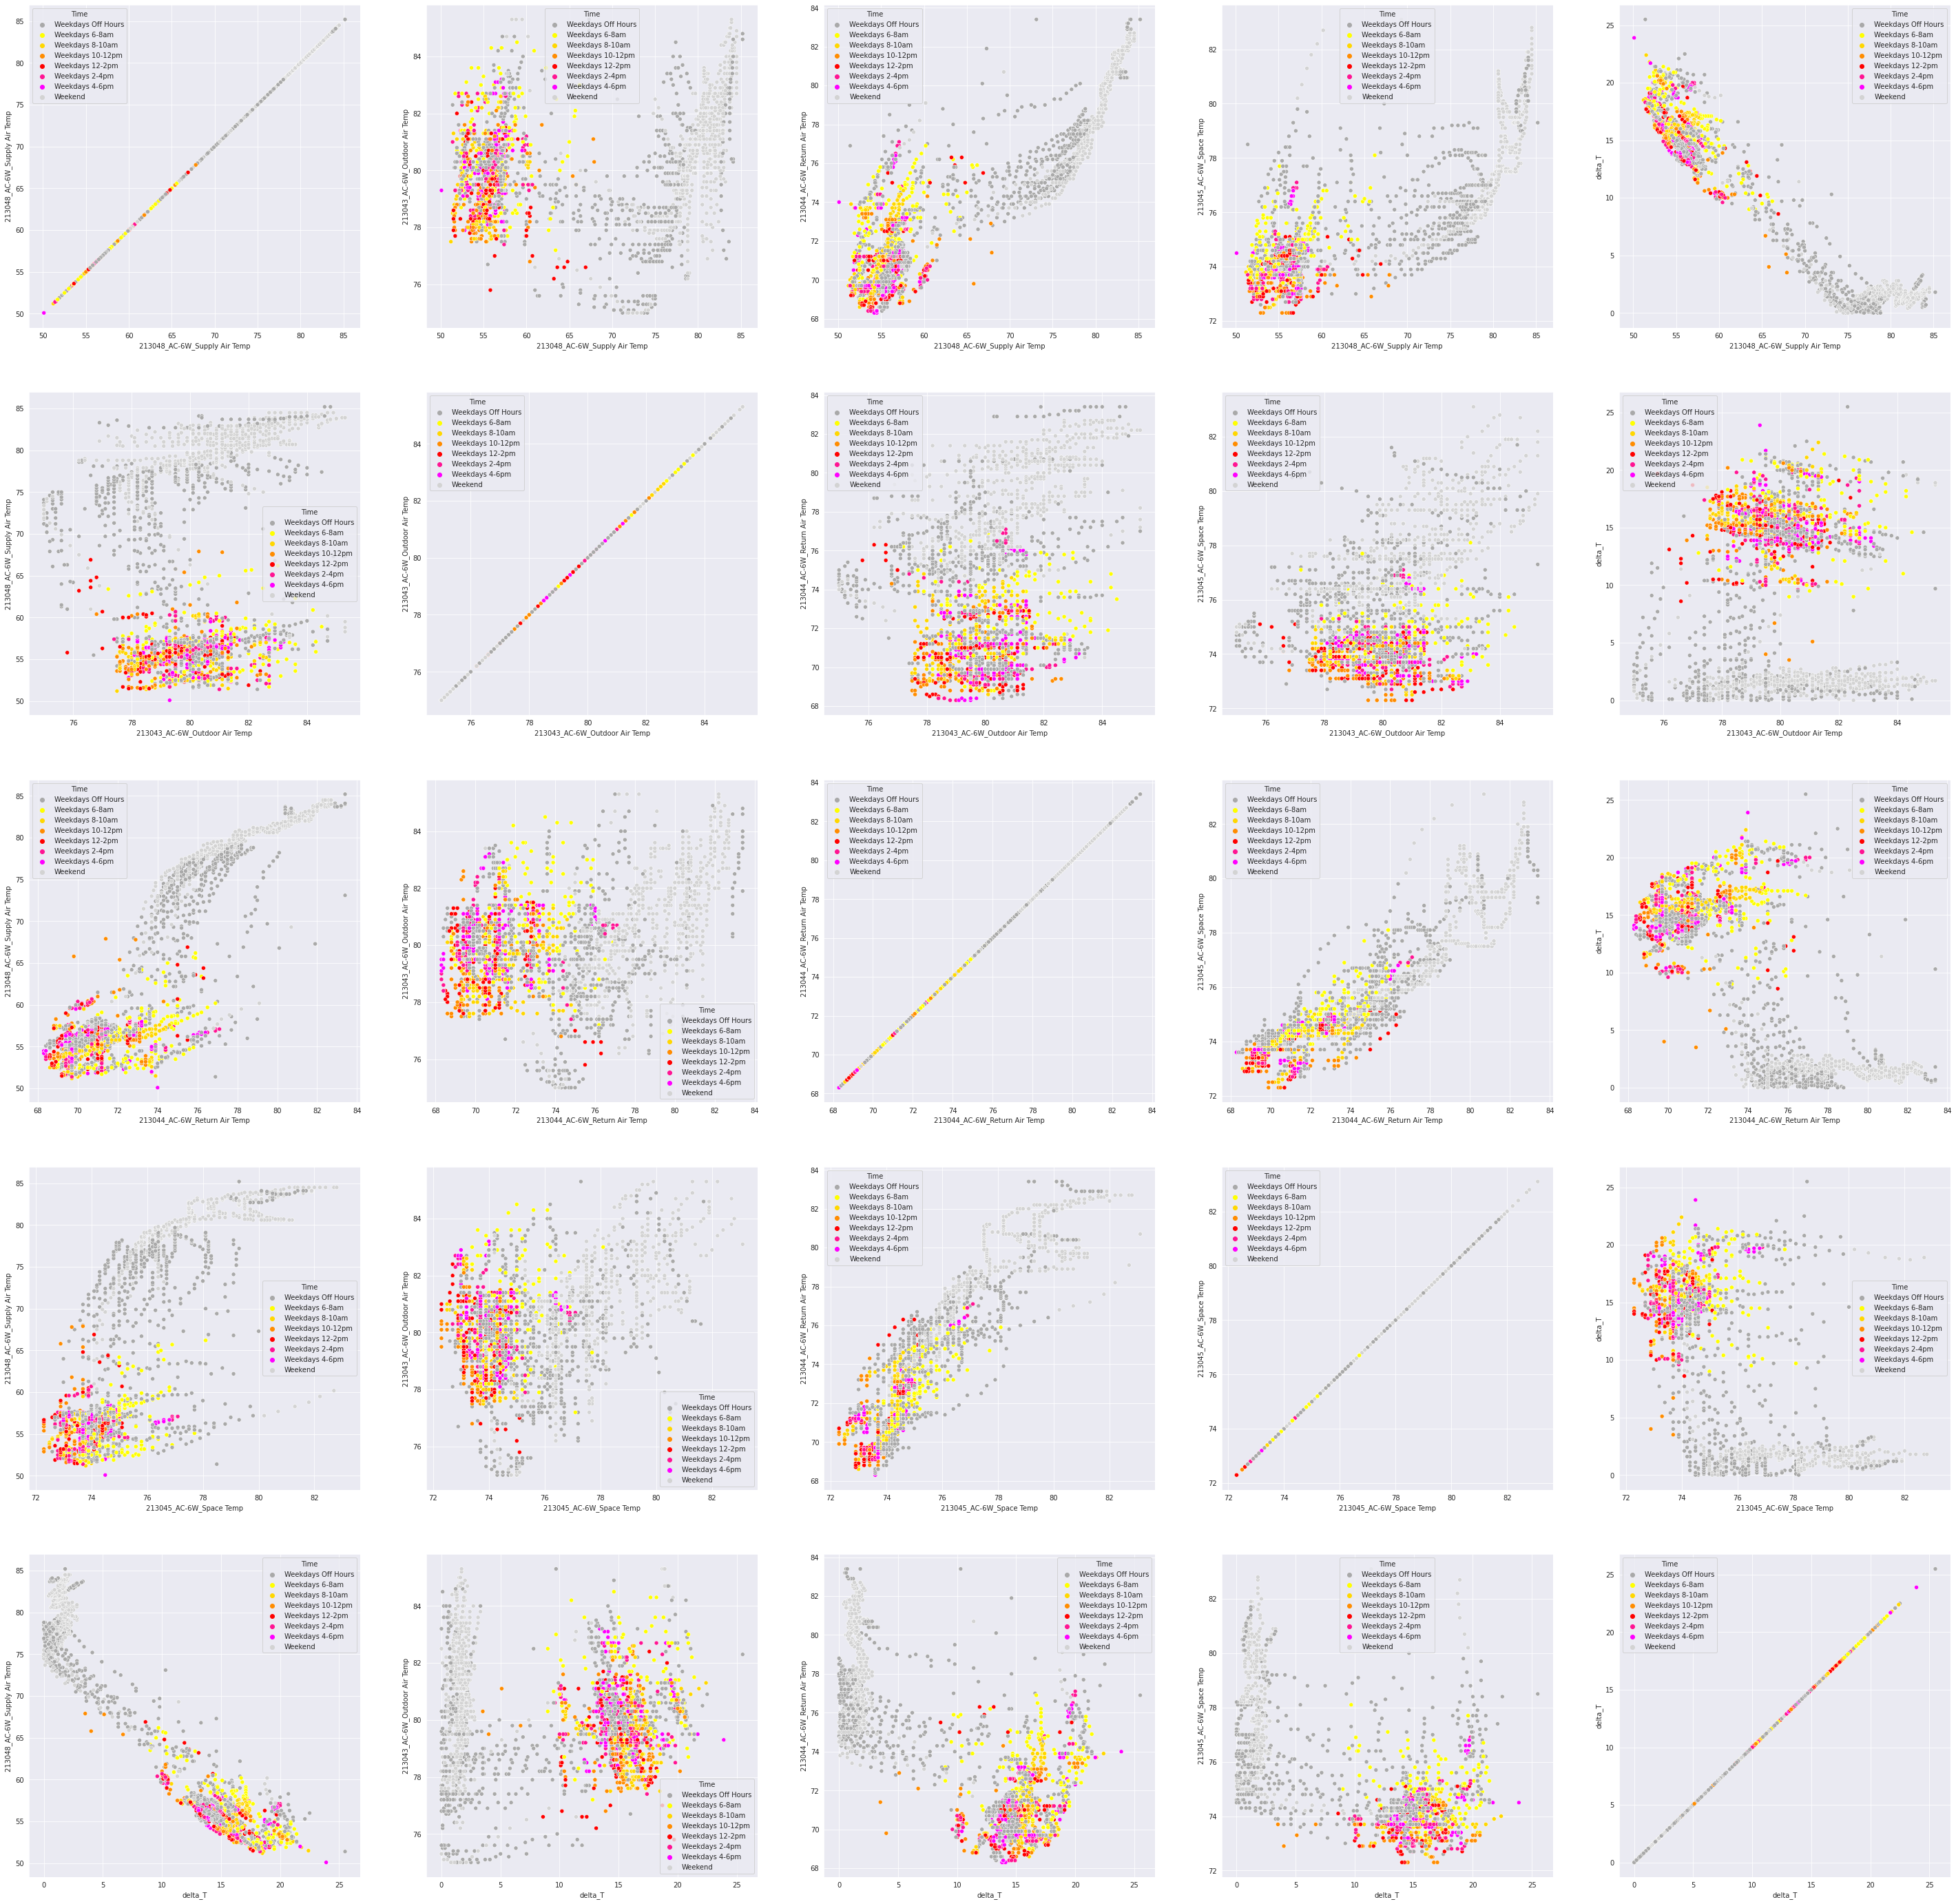

In [28]:
cols = timeseries_b286_f6_renamed.columns.tolist()[:-1] #get all columns except last one 'Time'
fig,ax = plt.subplots(len(cols),len(cols),figsize=(len(cols)*10,len(cols)*10))
#markers = {'Weekend': '+', 'Weekday': 'x'}
#sizes = {'Weekend': 100, 'Weekday': 40}

markers = dict({'Weekend':'o', 'Weekdays Off Hours':'o','Weekdays 6-8am':'^',
               'Weekdays 8-10am':'^','Weekdays 10-12pm':'^','Weekdays 12-2pm':'^',
               'Weekdays 2-4pm':'^','Weekdays 4-6pm':'^'})
colors = dict({'Weekend':'lightgray', 'Weekdays Off Hours':'darkgray','Weekdays 6-8am':'yellow',
               'Weekdays 8-10am':'gold','Weekdays 10-12pm':'darkorange','Weekdays 12-2pm':'red',
               'Weekdays 2-4pm':'deeppink','Weekdays 4-6pm':'fuchsia'})

for i in np.arange(len(cols)):
  for j in np.arange(len(cols)):
    sns.set_style('darkgrid')
    sns.scatterplot(ax=ax[i][j],data=timeseries_b286_f6_renamed,x=cols[i],y=cols[j],hue='Time',palette=colors,markers=markers)
    #sns.kdeplot(ax=ax[i][j],data=timeseries_b286_f6_renamed,x=cols[i],y=cols[j],hue='Time',palette=colors)
    #sns.jointplot(ax=ax[i][j],timeseries_b286_f6_renamed,x=cols[i],y=cols[j],hue='Time',kind='kde')

plt.savefig('timeseries_b286_f6_final.png') 
files.download('timeseries_b286_f6_final.png')

In [ ]:
"""
cols = timeseries_b286_f6_diffs_renamed.columns.tolist()[:-1] #get all columns except last one 'Time'
fig,ax = plt.subplots(len(cols),len(cols),figsize=(len(cols)*10,len(cols)*10))
markers = {'Weekend': '+', 'Weekday': 'x'}
sizes = {'Weekend': 100, 'Weekday': 40}

for i in np.arange(len(cols)):
  for j in np.arange(len(cols)):
    sns.scatterplot(ax=ax[i][j],data=timeseries_b286_f6_renamed,x=cols[i],y=cols[j],hue='Time',palette=colors,markers=markers)

plt.savefig('timeseries_b286_f6_diffs_v5.pdf') 
files.download('timeseries_b286_f6_diffs_v5.pdf')
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

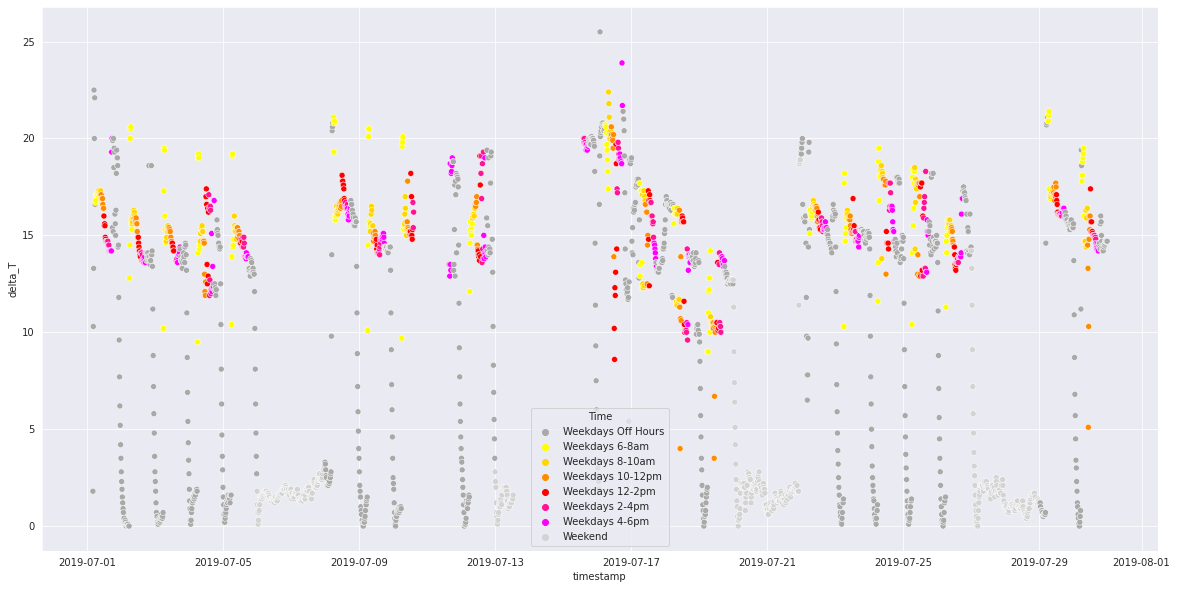

In [33]:
fig,ax = plt.subplots(1,1,figsize=(20,10))

colors = dict({'Weekend':'lightgray', 'Weekdays Off Hours':'darkgray','Weekdays 6-8am':'yellow',
               'Weekdays 8-10am':'gold','Weekdays 10-12pm':'darkorange','Weekdays 12-2pm':'red',
               'Weekdays 2-4pm':'deeppink','Weekdays 4-6pm':'fuchsia'})
sns.set_style('darkgrid')

sns.scatterplot(ax=ax,data=timeseries_b286_f6_renamed,x=timeseries_b286_f6_renamed.index, y='delta_T',hue='Time',palette=colors)

plt.savefig('deltat_timeseries_b286_final.png') 
files.download('deltat_timeseries_b286_final.png')
#sns.scatterplot(ax=ax,data=timeseries_b286_f6,x=timeseries_b286_f6.index, y=15)
#sns.scatterplot(ax=ax,data=timeseries_b286_f6,x=timeseries_b286_f6.index, y=22)